In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import cmocean.cm as cmo
import matplotlib.gridspec as gridspec

# Animate Barotropic Streamfunction (BSF) for CESM2 LENS2 data
# - Set up regional mask and file paths
# - Load and process dataset
# - Replace non-finite values in coordinates
# - Create contour plot and animation
# - Save BSF animation as MP4 file

start BSF


NameError: name 'levels' is not defined

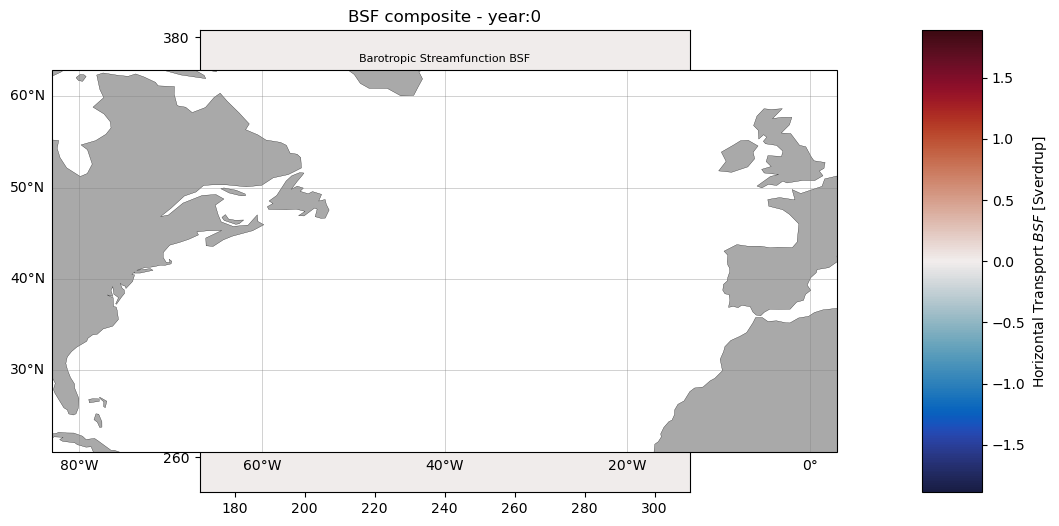

In [7]:
bsf_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc'
ds_bsf = xr.open_dataarray(bsf_file)

ps_file = '/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/temp/temp_1231.001.nc'
ds_ps = xr.open_dataset(ps_file).isel(time=0, z_t=0).squeeze()

replacement_value = 0
# Replace non-finite values and masked values
ds_ps['ULAT'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULAT']), np.isinf(ds_ps['ULAT']) | np.ma.getmask(ds_ps['ULAT'])),
    replacement_value,
    ds_ps['ULAT'])

ds_ps['ULONG'] = xr.where(
    np.logical_or(np.isnan(ds_ps['ULONG']), np.isinf(ds_ps['ULONG']) | np.ma.getmask(ds_ps['ULONG'])),
    replacement_value,
    ds_ps['ULONG'])

vmin = -8
vmax = -vmin

ds = ds_bsf.roll(nlon=+100).isel(nlat=slice(250,365))
ps_ds = ds_ps.isel(nlat=slice(250,365))

print('start BSF')

cmap = cmo.balance

time_dependent_fields = xr.open_dataarray('/Data/gfi/share/ModData/CESM2_LENS2/ocean/monthly/comp/BSFcomposite-test.nc').isel(time=slice(0,3))

def plot_var_frame(time_step):
    data = ds.isel(time=start + time_step)
    ax1.cla()
    im = ax1.imshow(data, cmap=cmap, vmin=vmin, vmax=vmax) 
    contour = ax1.contour(data, colors='k')
    ax1.clabel(contour, inline=True, fontsize=8)

    ax1.set_xlim([170, 310])
    ax1.set_ylim([250, 382])
        
    ax1.set_title(f'BSF composite - year:{time_step}')

#ds = time_dependent_fields
ds = time_dependent_fields - time_dependent_fields.isel(time=0)

vmin, vmax = -abs(ds).max(), abs(ds).max()
start = 0

# Create figure and set up layout of subplots
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[13, 1])

# Main subplot for animation
ax1 = plt.subplot(gs[0])

# Colorbar subplot 
cax = plt.subplot(gs[1])
num_time_steps = len(ds.time)
ani = animation.FuncAnimation(fig, plot_var_frame, frames=num_time_steps, interval=800)

# Set colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Horizontal Transport $BSF$ [Sverdrup]')

# Base map setup
def setup_map(ax):
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '110m', linewidth=0.2, edgecolor='black', facecolor='darkgray'))
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.5, color='gray', alpha=0.5, linestyle='-',
                 draw_labels={'bottom': True, 'left': True, 'right': False, 'top': False, 'fontsize': 8})
    ax.set_extent([-83, 3, 21, 55])
    ax.set_title('Barotropic Streamfunction BSF', fontsize=8)

# Plot base map
ax = fig.add_subplot(1, 2, 1, projection=ccrs.PlateCarree())
setup_map(ax)

# Plot map and contours
cf = ax.contourf(ps_ds.ULONG, ps_ds.ULAT, ds, levels=levels, cmap=cmap)
cf2 = ax.contour(ps_ds.ULONG, ps_ds.ULAT, ds, levels=levels, colors=['#202020',],linewidths=0.5)

# Define the filename for the saved animation
save_filename = 'bsf_animation.mp4'

# Save animation
ani.save(save_filename, writer='ffmpeg', fps=3)

print(f'Animation saved as {save_filename}')
